# BEE 4750 Homework 5: Solid Waste Disposal

**Name**:

**ID**:

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [132]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/hw05-teaganraesmith`


In [133]:
#import Pkg; Pkg.add("LaTeXStrings")
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using LaTeXStrings

## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee ** (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:-------------:|:-------------:|:-------------:|:----------:|:--------------:|
|           Landfill           |         200         |         2000          |            50            |                            |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |                            |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:---------------------:|:--------------:|:---------------:|:---------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [134]:
PercentAsh=.15(.08)+.40(.07)+.05(.05)+0.03(.1)+.02(.15)+.05(.02)+.18(.02)+.04(1)+.02(1)+.02(1)+.01(1)+.03(.7)
PercentRecycle=.15(0)+.40(.55)+.05(.15)+0.03(.1)+.02(0)+.05(.30)+.18(.40)+.04(.60)+.02(.75)+.02(.8)+.01(.5)+.03(0)

print("The percent ash fraction is: ", PercentAsh, "   The percent recycling fraction is: ", PercentRecycle)

The percent ash fraction is: 0.16410000000000002   The percent recycling fraction is: 0.3775000000000001

#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

The decision variables are:
$$W_{i,j}$$ 
Which is waste transported from city to disposal (Mg/day)

$$R_{k,j}$$ 
Which is residual waste transported from disposal to disposal (Mg/day)

$$Y_j$$
Which is Operational status (on/off) of disposal j (binary)

#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

Minimization of Transportation Costs=$$\sum_{i∈I, j∈J}a_{i,j}*l_{i,j}*W_{i,j}$$
$$a_{i,j}$$ 
Is the Cost of transporting waste from source to disposal j ($/Mg-km)
$$l_{i,j}$$
Is the distance between source i and disposal j (km)

The other objective piece is Minimization of Disposal Cost=
$$\sum_{j∈J}(c_{j}+b_{j}*\sum_{i∈I}W_{i,j})$$
$$c_j$$
Is fixed costs of operating disposal j ($/day)
$$b_j$$
Is variable cost of disposing waste at disposal j ($/Mg)

The option of operate or not operate a disposal facility j needs an indicator variable:
 $$ Y_j=   \left\{
\begin{array}{ll}
      0 & \sum_{i∈I}W_{i,j}=0 \\
      1 & \sum_{i∈I}W_{i,j}>0  \\
\end{array} 
\right.  $$

To determine total cost, the terms are derived and summed below:
\begin{align}
&\text {LF = $2000Y_1 + 50(W_{1,1}+W_{2,1}+W_{3,1}+R_{2,1}+R_{3,1})  $} \notag
&&\\
&\text {MRF = $1500Y_2 + (7+(40*0.3775))(W_{1,2}+W_{2,2}+W_{3,2}) $} \notag
&&\\ 
&\text {WTE = $2500Y_3 +60(W_{1,3}+W_{2,3}+W_{3,3}+R_{2,3}) $ } \notag
&&\\ \notag
&&\\ \notag
&\text {Transportation Cost = $1.5(5(W_{1,1})+30(W_{1,2})+15(W_{1,3}) $} \notag
&&\\ 
&\text {$+15(W_{2,1})+25(W_{2,2})+10(W_{2,3})+13(W_{3,1})+45(W_{3,2})+20(W_{3,3})+15(R_{2,3})+32(R_{2,1})+18(R_{3,1}) $} \notag
&&\\ \notag
&&\\ \notag
&\text {Total Cost = $2000Y_1 +1500Y_2 + 2500Y_3 + 57.5(W_{1,1})+67.1(W_{1,2})$} \notag
&&\\ 
&\text {$+82.5(W_{1,3})+72.5(W_{2,1})+59.6(W_{2,2})+75(W_{2,3})+69.5(W_{3,1})+89.6(W_{3,2})+90(W_{3,3})   $} \notag
&&\\ 
&\text {$+82.5(R_{2,3})+98(R_{2,1})+77(R_{3,1}) $} \notag
\end{align}

#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

1. Need to dispose of all waste from each source i:

\begin{align}
\sum_{j \in J} W_{i,j} = S_i \notag
\end{align}

2. Total waste per day from each city i:
\begin{align}
\text{$\sum_{j \in J} W_{1,j}= 100$ Mg/day}\notag
\\
\text{$\sum_{j \in J} W_{2,j} = 90$ Mg/day}\notag
\\
\text{$\sum_{j \in J} W_{3,j} = 120$ Mg/day}\notag
\end{align}

3. Capacity limit (K) at each disposal site j:

\begin{align}
\sum_{i \in I} W_{i,j} \leq K_j \notag
\end{align}

\begin{align}
&\text{$\sum_{i \in I} W_{i,1} + \sum_{i \in I} R_{i,1} \leq 200$ - Landfill}\notag
&&\\
&\text{$\sum_{i \in I} W_{i,2} + \sum_{i \in I} R_{i,2} \leq 350$ - Materials Recycling Facility}\notag
&&\\
&\text{$\sum_{i \in I} W_{i,3} + \sum_{i \in I} R_{i,2} \leq 210$ - Waste to Energy}\notag
\end{align}


4. Non-Negativity Constraint for $W_{i,j}$ and $R_{i,j}$ :

\begin{align}
\sum_{i \in I, j \in J} W_{i,j} \ge 0 \notag
\sum_{i \in I, j \in J} R_{i,j} \ge 0 \notag
\end{align}

5. Not all waste will burn the same - the ash rate depends on the waste composition:
\begin{align}
\frac{\sum (\text{fraction of waste} \ast (1-MRF rate) \ast (\text{ash rate}))}{\sum (\text{fraction of waste} \ast (1-MRF rate))} \notag
 \end{align}

\begin{align}
\text{To find this, we used an Excel sheet listed here:}
\end{align}
 https://docs.google.com/spreadsheets/d/1pX514uWSZ5Z4MUUwGLZ7csAsSR1hl1FxVSCANxVJij0/edit?usp=sharing

This came out to 0.1386. 

6. Commitment (need to use Big M):
The addition of the Big M constraint allows us to be able to better see changes made in the model. Big M is a large value.
\begin{align}
&\text {$M=1000$}\notag
&&\\
&\text {$M*\sum_{j \in J} Y_{j} \ge \sum_{j \in J}K_{j}$}\notag
&&\\
&\text{$M*Y_1 \ge \sum_{i \in I} W_{i,1} + \sum_{i \in I} R_{i,1}$ - Landfill}\notag
&&\\
&\text{$M*Y_2 \ge \sum_{i \in I} W_{i,2} + \sum_{i \in I} R_{i,2}$ - Materials Recycling Facility}\notag
&&\\
&\text{$M*Y_3 \ge \sum_{i \in I} W_{i,3} + \sum_{i \in I} R_{i,3}$ - Waste to Energy}\notag
\end{align}


#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [135]:
using JuMP
using HiGHS
waste=Model(HiGHS.Optimizer)
I=1:3
J=1:3
K=1:3

#Defining Variables
@variable(waste, W[i in I, j in J] >= 0) #units: Mg/day
@variable(waste, R[k in K, j in J] >= 0) #units: Mg/day
@variable(waste, Y[j in J],Bin)

#Defining Objective As Derived Above
@objective(waste, Min, 2000*Y[1]+1500*Y[2]+ 2500*Y[3]+57.5(W[1,1])+
67.1(W[1,2])+82.5(W[1,3])+72.5(W[2,1])+59.6(W[2,2])+75(W[2,3])+69.5(W[3,1])+
89.6(W[3,2])+90(W[3,3])+22.5(R[2,3])+98(R[2,1])+77(R[3,1])+82.5(R[2,3])+98(R[2,1])+77(R[3,1]))

#Defining Constraints
#City Mass Balance Constraints
@constraint(waste, city1, W[1,1]+W[1,2]+W[1,3]==100);
@constraint(waste, city2, W[2,1]+W[2,2]+W[2,3]==90);
@constraint(waste, city3, W[3,1]+W[3,2]+W[3,3]==120);
#Residual Mass Balance Constraints
@constraint(waste, WTE_Return, R[3,1]==PercentAsh*(W[1,3]+W[2,3]+W[3,3])+0.1386*R[2,3]); 
@constraint(waste, MRF_Return, R[2,1]+R[2,3]==(1-PercentRecycle)*(W[1,2]+W[2,2]+W[3,2])); #(1-recycling fraction)
#Disposal Limit Constraints
@constraint(waste, LF, W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]<=200); 
@constraint(waste, MRF, W[1,2]+W[2,2]+W[3,2]<=350); 
@constraint(waste, WTE, W[1,3]+W[2,3]+W[3,3]+R[2,3]<=210);
#Commitment Constraints
M=1000 #Big M Reformulation Needed
@constraint(waste, commit1, M*Y[1] >= W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]);
@constraint(waste, commit2, M*Y[2] >= W[1,2]+W[2,2]+W[3,2]);
@constraint(waste, commit3, M*Y[3] >= W[1,3]+W[2,3]+W[3,3]+R[2,3]);

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [136]:
optimize!(waste)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10 rows, 15 cols, 43 nonzeros
8 rows, 13 cols, 35 nonzeros

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   35 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   2000            inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   2000            29518.273119      93.22%        0      0      0         0     0.0s
         0       0         0   0.00%   27672.354775    29518.273119       6.25%        0      0      0         5     0.0s

Solving report
  Status            Optimal
  Primal bound      29518.2731188
  Dual bound        29518.2731188
  Gap           

In [137]:
Waste=value.(W.data);
print("Waste from City 1 to LF: ", Waste[1,1], " mg/day.  ", "  Waste from City 1 to MRF: ", Waste[1,2], " mg/day.  ", "  Waste from City 1 to WTE: ", Waste[1,3], " mg/day.")

Waste from City 1 to LF: 100.0 mg/day.    Waste from City 1 to MRF: 0.0 mg/day.    Waste from City 1 to WTE: 0.0 mg/day.

In [138]:
print("Waste from City 2 to LF: ", abs(Waste[2,1]), " mg/day.  ", "  Waste from City 2 to MRF: ", abs(Waste[2,2]), " mg/day.  ", "  Waste from City 2 to WTE: ", Waste[2,3], " mg/day.")

Waste from City 2 to LF: 0.0 mg/day.    Waste from City 2 to MRF: 0.0 mg/day.    Waste from City 2 to WTE: 90.0 mg/day.

In [139]:
print("Waste from City 3 to LF: ", abs(Waste[3,1]), " mg/day.  ", "  Waste from City 3 to MRF: ", abs(Waste[3,2]), " mg/day.  ", "  Waste from City 3 to WTE: ", Waste[3,3], " mg/day.")

Waste from City 3 to LF: 78.40531164014834 mg/day.    Waste from City 3 to MRF: 0.0 mg/day.    Waste from City 3 to WTE: 41.59468835985163 mg/day.

In [140]:
Residual=value.(R.data);
print("Residuals from WTE to Landfill: ", Residual[3,1], " mg/day.")

Residuals from WTE to Landfill: 21.594688359851656 mg/day.

#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

The facilities which are not used are MRF. This could be that it is just too expensive to have the cities pay the additional recycling fee when they are trying to minimize cost. From a sustainability standpoint, this solution does not make sense, but from what is being optimized (cost alone) in the model, it does make sense.

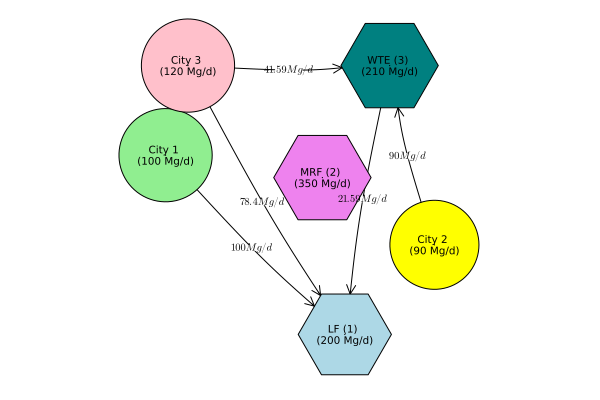

In [141]:
using GraphRecipes, Plots

A = [0 0 0 1 0 0 ;
    0 0 0 0 0 1 ;
    0 0 0 1 0 1 ;
    0 0 0 0 0 0 ;
    0 0 0 0 0 0 ;    
    0 0 0 1 0 0 ]

names = ["City 1 \n(100 Mg/d)", "City 2 \n(90 Mg/d)", "City 3 \n(120 Mg/d)", "LF (1) \n(200 Mg/d)", "MRF (2) \n(350 Mg/d)", "WTE (3) \n(210 Mg/d)"]
# modify this dictionary to add labels
edge_labels = (Dict((1, 4) => L"100 Mg/d", (2,6) => L"90 Mg/d", (6, 4) => L"21.59 Mg/d", 
            (3, 6) => L"41.59 Mg/d",(3, 4) => L"78.4 Mg/d"))
shapes=[:circ, :circ, :circ, :hexagon, :hexagon, :hexagon]
colors=[:lightgreen, :yellow, :pink, :lightblue, :violet, :teal]
xpos = [-1, 2., -0.75, 1, .75, 1.5]
ypos = [1, 0, 2, -1, .75, 2]

graphplot(A, names=names, edgelabel=edge_labels, edgelabels_boxes = true, fontsize = 7, markersize=0.23, markercolors=colors, markershapes=shapes, x=xpos, y=ypos, label=["Units: Mg/day for all numbers"])

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

To determine the new total cost, the terms are derived and summed below:
Initially, the quantity of j disposal goes from 3 to 4, which also means that there will be an addition of a Y[4] term for the second landfill's indicator variable.
\begin{align}
&\text {LF1 = $2000Y_1 + 50(W_{1,1}+W_{2,1}+W_{3,1}+R_{2,1}+R_{3,1})  $} \notag
&&\\
&\text {LF2 = $2000Y_4 + 60(W_{1,4}+W_{2,4}+W_{3,4}+R_{2,4}+R_{3,4})  $} \notag
&&\\
&\text {MRF = $1500Y_2 + (7+(40*0.3775))(W_{1,2}+W_{2,2}+W_{3,2}) $} \notag
&&\\ 
&\text {WTE = $2500Y_3 +75(W_{1,3}+W_{2,3}+W_{3,3}+R_{2,3}) $ } \notag
&&\\ \notag
&&\\ \notag
&\text {Transportation Cost = $2(5(W_{1,1})+30(W_{1,2})+15(W_{1,3})+45(W_{1,4})  $} \notag
&&\\ 
&\text{$+15(W_{2,1})+25(W_{2,2})+10(W_{2,3})+35(W_{2,4})+13(W_{3,1})+45(W_{3,2})  $} \notag
&&\\
&\text{$+20(W_{3,3})+15(W_{3,4})+15(R_{2,3})+32(R_{2,1})+35(R_{2,4})+18(R_{3,1}+50(R_{3,4})) $} \notag
&&\\ \notag
&&\\ \notag
&\text {Total Cost = $2000Y_1 +1500Y_2 + 2500Y_3 + 2500Y_4 + 60(W_{1,1})+82.1(W_{1,2})  $} \notag
&&\\ 
&\text {$+105(W_{1,3})+150(W_{1,4})+80(W_{2,1})+72.1(W_{2,2})+95(W_{2,3})+130(W_{2,4})+76(W_{3,1})+112.1(W_{3,2})+115(W_{3,3}+160(W_{3,4}))   $} \notag
&&\\ 
&\text {$+105(R_{2,3})+114(R_{2,1})+86(R_{3,1}+130(R_{2,4})+160(R_{3,4})) $} \notag
\end{align}

Additionally, the city constraints will have to incorporate the waste they transport to landfill 2 which is designated as the 4th column:
$$@constraint(waste, city1, W[1,1]+W[1,2]+W[1,3]+W[1,4]==100);$$
$$@constraint(waste, city2, W[2,1]+W[2,2]+W[2,3]+W[2,4]==90);$$
$$@constraint(waste, city3, W[3,1]+W[3,2]+W[3,3]+W[3,4]==120);$$

The residual mass balance constraints will also have to incorporate this term:
$$@constraint(waste, WTE_Return, R[3,1]+R[4,1]==PercentAsh*(W[1,3]+W[2,3]+W[3,3])+0.1386*R[2,3])$$
$$@constraint(waste, MRF_Return, R[2,1]+R[2,3]+R[2,4]==(1-PercentRecycle)*(W[1,2]+W[2,2]+W[3,2]));$$

The disposal limit constraints will be edited as below to include the new landfill's maximum intake:
$$@constraint(waste, LF2, W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]<=100); $$

Finally, the commitment constraints will have to add a term for the new landfill:
$$@constraint(waste, commit3, M*Y[4] >= W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]);$$


#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [142]:
using JuMP
using HiGHS
waste=Model(HiGHS.Optimizer)
I=1:3
J=1:4
K=1:4

#Defining Variables
@variable(waste, W[i in I, j in J] >= 0) #units: Mg/day
@variable(waste, R[k in K, j in J] >= 0) #units: Mg/day
@variable(waste, Y[j in J],Bin)

#Defining Objective As Derived Above
@objective(waste, Min, 2000*Y[1]+1500*Y[2]+ 2500*Y[3]+2000*Y[4]+60(W[1,1])+
82.1(W[1,2])+105(W[1,3])+150(W[1,4])+80(W[2,1])+72.1(W[2,2])+95(W[2,3])+130(W[2,4])+76(W[3,1])+
112.1(W[3,2])+115(W[3,3])+160(W[3,4])+105(R[2,3])+114(R[2,1])+130(R[2,4])+86(R[3,1])+160(R[3,4]))

#Defining Constraints
#City Mass Balance Constraints
@constraint(waste, city1, W[1,1]+W[1,2]+W[1,3]+W[1,4]==100);
@constraint(waste, city2, W[2,1]+W[2,2]+W[2,3]+W[2,4]==90);
@constraint(waste, city3, W[3,1]+W[3,2]+W[3,3]+W[3,4]==120);
#Residual Mass Balance Constraints
@constraint(waste, WTE_Return, R[3,1]+R[3,4]==PercentAsh*(W[1,3]+W[2,3]+W[3,3])+0.1386*R[2,3]);
@constraint(waste, MRF_Return, R[2,1]+R[2,3]+R[2,4]==(1-PercentRecycle)*(W[1,2]+W[2,2]+W[3,2])); 
#Disposal Limit Constraints
@constraint(waste, LF1, W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]<=200); 
@constraint(waste, MRF, W[1,2]+W[2,2]+W[3,2]<=350); 
@constraint(waste, WTE, W[1,3]+W[2,3]+W[3,3]+R[2,3]<=210);
@constraint(waste, LF2, W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]<=100); 

#Commitment Constraints
M=1000 #Big M Reformulation Needed
@constraint(waste, commit1, M*Y[1] >= W[1,1]+W[2,1]+W[3,1]+R[2,1]+R[3,1]);
@constraint(waste, commit2, M*Y[2] >= W[1,2]+W[2,2]+W[3,2]);
@constraint(waste, commit3, M*Y[3] >= W[1,3]+W[2,3]+W[3,3]+R[2,3]);
@constraint(waste, commit4, M*Y[4] >= W[1,4]+W[2,4]+W[3,4]+R[2,4]+R[3,4]);

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [143]:
optimize!(waste)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12 rows, 21 cols, 59 nonzeros
12 rows, 21 cols, 59 nonzeros

Solving MIP model with:
   12 rows
   21 cols (4 binary, 0 integer, 0 implied int., 17 continuous)
   59 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   0               31649.336045     100.00%        0      0      0         0     0.0s
         0       0         0   0.00%   28481.410233    31649.336045      10.01%        0      0      0         9     0.0s

Solving report
  Status            Optimal
  Primal bound      31649.336045
  Dual bound        31649.336045
  Gap           

In [144]:
Waste=value.(W.data);
print("Waste from City 1 to LF1: ", Waste[1,1], " mg/day.  ", "  Waste from City 1 to MRF: ", Waste[1,2], " mg/day.  ", "  Waste from City 1 to WTE: ", Waste[1,3], " mg/day.  ", "  Waste from City 1 to LF2: ", Waste[1,4], " mg/day.")

Waste from City 1 to LF1: 100.0 mg/day.    Waste from City 1 to MRF: 0.0 mg/day.    Waste from City 1 to WTE: 0.0 mg/day.    Waste from City 1 to LF2: 0.0 mg/day.

In [145]:
print("Waste from City 2 to LF1: ", abs(Waste[2,1]), " mg/day.  ", "  Waste from City 2 to MRF: ", abs(Waste[2,2]), " mg/day.  ", "  Waste from City 2 to WTE: ", Waste[2,3], " mg/day.  ", "  Waste from City 2 to LF2: ", abs(Waste[2,4]), " mg/day.")

Waste from City 2 to LF1: 0.0 mg/day.    Waste from City 2 to MRF: 0.0 mg/day.    Waste from City 2 to WTE: 90.0 mg/day.    Waste from City 2 to LF2: 0.0 mg/day.

In [146]:
print("Waste from City 3 to LF1: ", abs(Waste[3,1]), " mg/day.  ", "  Waste from City 3 to MRF: ", abs(Waste[3,2]), " mg/day.  ", "  Waste from City 3 to WTE: ", Waste[3,3], " mg/day.  ", "  Waste from City 3 to LF 2: ", Waste[3,4], " mg/day.")

Waste from City 3 to LF1: 78.40531164014833 mg/day.    Waste from City 3 to MRF: 0.0 mg/day.    Waste from City 3 to WTE: 41.59468835985167 mg/day.    Waste from City 3 to LF 2: 0.0 mg/day.

In [147]:
print("Waste from City 3 to LF: ", abs(Waste[3,]), " mg/day.  ", "  Waste from City 3 to MRF: ", abs(Waste[3,2]), " mg/day.  ", "  Waste from City 3 to WTE: ", Waste[3,3], " mg/day.")

Waste from City 3 to LF: 78.40531164014833 mg/day.    Waste from City 3 to MRF: 0.0 mg/day.    Waste from City 3 to WTE: 41.59468835985167 mg/day.

In [148]:
Residual=value.(R.data)
print("Residuals from Landfill 1 to Landfill 2: ", Residual[3,1], " mg/day.")

Residuals from Landfill 1 to Landfill 2: 21.594688359851663 mg/day.

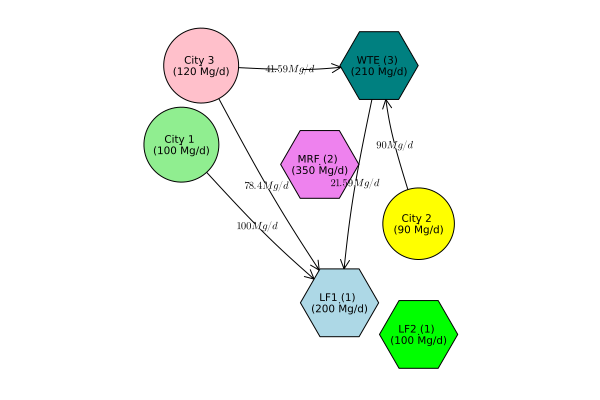

In [149]:
using GraphRecipes, Plots

A = [0 0 0 1 0 0 0;
    0 0 0 0 0 1 0;
    0 0 0 1 0 1 0;
    0 0 0 0 0 0 0;
    0 0 0 0 0 0 0;    
    0 0 0 1 0 0 0;
    0 0 0 0 0 0 0]

names = ["City 1 \n(100 Mg/d)", "City 2 \n(90 Mg/d)", "City 3 \n(120 Mg/d)", "LF1 (1) \n(200 Mg/d)", "MRF (2) \n(350 Mg/d)", "WTE (3) \n(210 Mg/d)",  "LF2 (1) \n(100 Mg/d)"]
# modify this dictionary to add labels
edge_labels = (Dict((1, 4) => L"100 Mg/d", (2,6) => L"90 Mg/d", (6, 4) => L"21.59 Mg/d", 
            (3, 6) => L"41.59 Mg/d",(3, 4) => L"78.4 Mg/d"))
shapes=[:circ, :circ, :circ, :hexagon, :hexagon, :hexagon, :hexagon]
colors=[:lightgreen, :yellow, :pink, :lightblue, :violet, :teal, :lime]
xpos = [-1, 2., -0.75, 1, .75, 1.5, 2]
ypos = [1, 0, 2, -1, .75, 2, -1.4]

graphplot(A, names=names, edgelabel=edge_labels, edgelabels_boxes = true, fontsize = 7, markersize=0.23, markercolors=colors, markershapes=shapes, x=xpos, y=ypos, label=["Units: Mg/day for all numbers"])

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

I would not recommend that the cities build a new landfill. Clearly, the cost of transporting the waste to this landfill would not minimize their overall cost, and it is just not necessary. All of the waste can easily be handled by the other three facilities so adding a fourth is not helpful. If the intake of waste was to go up, then they might begin to need the landfill. Or, say, there were environmental regulations placed on WTE plants which charged them money for the quantity of waste they burn, then less waste would go to them and more might need to go to a landfill. 

## References

List any external references consulted, including classmates.

I consulted with Emma-Rose Connolly, Mia Rusk, and Gaby Ackermann Logan the TA. 